In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sqlalchemy import create_engine
import mysql.connector
import pickle

%matplotlib inline

In [2]:
import getpass  # To get the password without showing the input
password = getpass.getpass()

········


In [3]:
# Connect to MySQL database
conn = mysql.connector.connect(host='127.0.0.1', user='root', passwd=password)
cursor = conn.cursor()

#Select the database
cursor.execute("USE vanguard")

In [4]:
#pulling data from mysql workbench
cursor.execute("""
                    SELECT clients.client_id,
                        clients.clnt_age, 
                        clients.gendr, 
                        COUNT(distinct(interactions.process_step)) AS count_of_steps,
                        group_id.variation
                    FROM clients
                    JOIN interactions
                    ON clients.client_id = interactions.client_id
                    INNER JOIN group_id
                    ON group_id.client_id = clients.client_id
                    GROUP BY clients.client_id, clients.clnt_age, clients.gendr,group_id.variation;

                    """)
results = cursor.fetchall()

how_far = pd.DataFrame(results)

In [5]:
#rename columns to be descriptive

how_far.rename(columns = {0:'client_id',1:'age',2:'gender',3:'steps_reached',4:'group_status'},inplace=True)
how_far

# Frequency table how many people reached and stopped at each step
frequency_table = how_far['steps_reached'].value_counts()

# Calculating the proportion of people that reached and stopped at each step
proportion_table = how_far['steps_reached'].value_counts(normalize=True)

proportion_table, frequency_table


(steps_reached
 5    0.664238
 1    0.118436
 4    0.093129
 2    0.069347
 3    0.054851
 Name: proportion, dtype: float64,
 steps_reached
 5    33544
 1     5981
 4     4703
 2     3502
 3     2770
 Name: count, dtype: int64)

In [6]:
how_far

,client_id,age,gender,steps_reached,group_status
0,1000062,52.5,F,5,Control
1,1000353,59.0,U,5,Control
2,1000536,27.0,U,5,Control
3,1000672,65.5,F,5,Control
4,1001101,61.5,M,5,Test
...,...,...,...,...,...
50495,9999150,30.0,U,2,Test
50496,9999400,28.5,U,5,Test
50497,9999626,35.0,M,2,Test
50498,9999729,31.0,F,5,Test


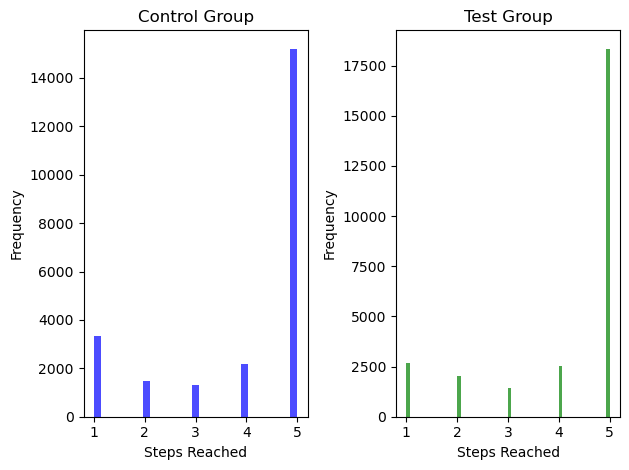

In [23]:
#filtering just to look at the group status and steps reached
how_far_filter = how_far[['group_status','steps_reached']]
how_far_filter

#making data frame for control and test groups
how_far_control = how_far_filter[how_far_filter['group_status'] == 'Control']
how_far_control

how_far_test = how_far_filter[how_far_filter['group_status'] == 'Test']
how_far_test

#histograms to see if data is normally distributed or not
plt.subplot(1, 2, 1)  # 1 row, 2 columns, 1st subplot
plt.hist(how_far_control['steps_reached'], bins='auto', alpha=0.7, color='blue')
plt.title("Control Group")
plt.xlabel("Steps Reached")
plt.ylabel("Frequency")

# Plotting histogram for Test group
plt.subplot(1, 2, 2)  # 1 row, 2 columns, 2nd subplot
plt.hist(how_far_test['steps_reached'], bins='auto', alpha=0.7, color='green')
plt.title("Test Group")
plt.xlabel("Steps Reached")
plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

#the U shape of the graphs show our data is not normally distributed (bell-curve), instead we have 2 peaks.

### Null Hypothesis: 
There is NO difference in completion rates between the control group and the test group.

### Alternative Hypothesis: 
There IS a difference in completion rates between the control group and the test group.

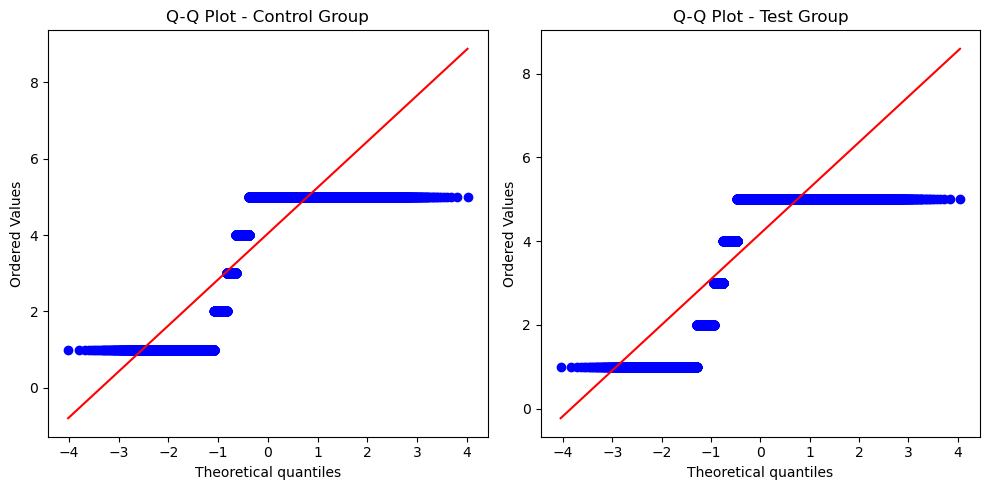

Shapiro-Wilk Test Control Group: Statistic=0.6519675254821777, p-value=0.0
Shapiro-Wilk Test Test Group: Statistic=0.6287720203399658, p-value=0.0


C:\Users\NessaJay\anaconda3\Lib\site-packages\scipy\stats\_morestats.py:1882: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")


In [24]:
import scipy.stats as stats

# Q-Q Plots
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
stats.probplot(how_far_control['steps_reached'], dist="norm", plot=plt)
plt.title("Q-Q Plot - Control Group")

plt.subplot(1, 2, 2)
stats.probplot(how_far_test['steps_reached'], dist="norm", plot=plt)
plt.title("Q-Q Plot - Test Group")

plt.tight_layout()
plt.show()

# Shapiro-Wilk Test
shapiro_control = stats.shapiro(how_far_control['steps_reached'])
shapiro_test = stats.shapiro(how_far_test['steps_reached'])

print(f"Shapiro-Wilk Test Control Group: Statistic={shapiro_control.statistic}, p-value={shapiro_control.pvalue}")
print(f"Shapiro-Wilk Test Test Group: Statistic={shapiro_test.statistic}, p-value={shapiro_test.pvalue}")

#the shapiro-wilk test confirms data is not normally distributed and the p-value means we reject null hypothesis

In [26]:
# Perform Mann-Whitney U Test
mannwhitney_test = stats.mannwhitneyu(how_far_control['steps_reached'], how_far_test['steps_reached'])

print(f"Mann-Whitney U Test: U-Statistic={mannwhitney_test.statistic}, p-value={mannwhitney_test.pvalue}")

# once again, we must reject the null hypothesis

Mann-Whitney U Test: U-Statistic=303782412.5, p-value=6.05188408797017e-23


C:\Users\NessaJay\AppData\Local\Temp\ipykernel_24368\2047214488.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  how_far_filter['steps_reached'] = how_far_filter['steps_reached'].astype(float)


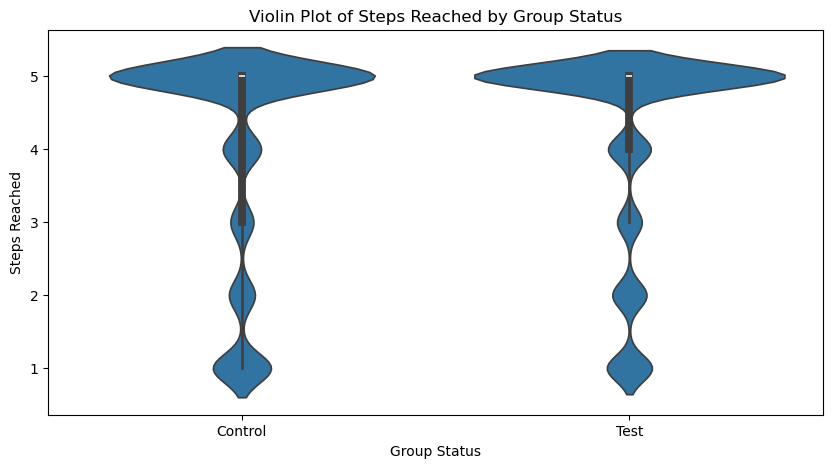

In [28]:
# Combine data for visualization
how_far_filter['steps_reached'] = how_far_filter['steps_reached'].astype(float)

# Create violin plots
plt.figure(figsize=(10, 5))
sns.violinplot(x='group_status', y='steps_reached', data=how_far_filter)
plt.title("Violin Plot of Steps Reached by Group Status")
plt.xlabel("Group Status")
plt.ylabel("Steps Reached")
plt.show()


In [10]:
#assuming everyone who completed went through all 5 steps
completed =  33544
dnf = 16956
initiated = 50500

# Calculate abandonment rate
abandonment_rate = (dnf / initiated) * 100
completion_rate = (completed / initiated) * 100

# Print abandonment rate
print("Abandonment rate of full group: {:.2f}%".format(abandonment_rate))
print("Completion rate of full group: {:.2f}%".format(completion_rate))



Abandonment rate of full group: 33.58%
Completion rate of full group: 66.42%


In [30]:
#let's look at the control group
with open('control_dnf.pkl', 'rb') as f:
    control_dnf = pickle.load(f)

control_dnf

with open('control_confirmed.pkl', 'rb') as f:
    control_confirmed = pickle.load(f)

control_confirmed

#8098 people from the control group abandoned the process
#15434 people from the control group completed the process
#the control group in total is 23532


#assuming everyone who completed went through all 5 steps
complete_control = 15434
dnf_control = 8098
initiated = 23532

# Calculate abandonment rate
abandonment_rate_control = (dnf_control / initiated) * 100
completion_rate_control = (complete_control / initiated) * 100

# Print abandonment rate
print("Abandonment rate of control group: {:.2f}%".format(abandonment_rate))
print("Completion rate of control group: {:.2f}%".format(completion_rate))


Abandonment rate of control group: 33.58%
Completion rate of control group: 66.42%


In [31]:
#let's look at the test group
with open('test_dnf.pkl', 'rb') as f:
    test_dnf = pickle.load(f)


with open('test_confirmed.pkl', 'rb') as f:
    test_confirmed = pickle.load(f)

# 8281 people from the test group abandoned the process
# 18687 people from the test group completed the process
# the test group in total is 26968


#assuming everyone who completed went through all 5 steps
complete_test = 18687
dnf_test = 8281
initiated = 26968

# Calculate abandonment rate
abandonment_rate_test = (dnf_test / initiated) * 100
completion_rate_test = (complete_test / initiated) * 100

# Print abandonment rate
print("Abandonment rate of test group: {:.2f}%".format(abandonment_rate))
print("Completion rate of test group: {:.2f}%".format(completion_rate))

Abandonment rate of test group: 33.58%
Completion rate of test group: 66.42%


In [45]:
# Step 1: Filter data by group
how_far_control
how_far_test

# Step 2: Count completed steps
complete_control_filter = how_far_control[how_far_control['steps_reached'] == 5]
complete_test_filter = how_far_test[how_far_test['steps_reached'] == 5]

control_completed = len(complete_control_filter)
test_completed = len(complete_test_filter)

# Step 3: Count total individuals
total_control_individuals = len(how_far_control)
total_test_individuals = len(how_far_test)

# Step 4: Calculate completion rate
control_completion_rate = (control_completed / total_control_individuals) * 100
test_completion_rate = (test_completed / total_test_individuals) * 100

print(f"Control Completion Rate: {control_completion_rate:.2f}%")
print(f"Test Completion Rate: {test_completion_rate:.2f}%")
print(f"Difference betweern rates:{round(test_completion_rate - control_completion_rate,2)}%")

Control Completion Rate: 64.62%
Test Completion Rate: 68.00%
Difference betweern rates:3.38%


In [47]:
# Perform Mann-Whitney U Test
mannwhitney_test = stats.mannwhitneyu(control_completion_rate, test_completion_rate)

# Print results
print(f"Mann-Whitney U Test: U-Statistic={mannwhitney_test.statistic}, p-value={mannwhitney_test.pvalue}")


# test result with a p-value of 1.0 suggests that this difference is not statistically significant. 
# the observed difference in completion rates between the control and test groups could likely occur 
# due to random chance or variability in the data.

Mann-Whitney U Test: U-Statistic=0.0, p-value=1.0


## Conclusions

The completion rates for the test group were better than the control group by about 3.38%. Based on our statistical analysis of the completion rates however, test result with a p-value of 1.0 suggests that this difference is not statistically significant. 

Additionally,the observed increase in completion rate does not meet the company's threshold of 5%, meaning the time, energy and resources needed to update the site would not be worth it. 


### Null Hypothesis: 
There is NO significant difference in completion rates between the control group and the test group.

### Alternative Hypothesis: 
There IS a significant difference in completion rates between the control group and the test group.


Since the p-value is high (greater than the conventional significance level of 0.05), we fail to reject the null hypothesis. Therefore, based on this analysis, there is insufficient evidence to conclude that the new website design improved completion rates compared to the old design. The observed difference in completion rates between the control and test groups could likely occur due to random chance or variability in the data.